Import packages

In [9]:
import sys
import pandas as pd
sys.path.append('..')
from LAD import *

Load sample data paths

In [7]:
lad_hr_pth = '../sample_data/CIR_Canadian_Shield.shp'
lad_lr_pth = '../sample_data/HydroLAKESv10_Sweden.shp'
lad_lr_oc_pth = '../sample_data/HydroLAKESv10_Sweden_Occurrence.csv.gz'
lev_pth = '../sample_data/LEV_Canadian_Shield.shp'
lev_csv_pth = '../sample_data/LEV_Canadian_Shield_train_s.csv'

Sample workflow for loading a low-resolution (LR) lake inventory, and extrapolating its lake and aquatic vegetation area using reference data.

In [10]:
## Load sample data (vegetation and lake area information)
lad_hl_oc = pd.read_csv(lad_lr_oc_pth, compression='gzip')
lad_lev_cat, ref_dfs = loadUAVSAR(ref_names=['CSB'], pths_shp=[lev_pth], pths_csv=[lev_csv_pth])


## Compute lake aquatic vegatation (LAV) from airborne data lake emergent vegetation (LEV) classification
lev = computeLAV(lad_hl_oc, ref_dfs, ['CSB'],
                extreme_regions_lev=['CSB', 'CSB']) # use same region for extremes bc limited sample data
lad_lev = LAD(lev, area_var='Lake_area', idx_var='Hylak_id', region_var='Country')

## Test binned LEV HL LAD (won't actually use this for analysis)
lad_lev.Region = 'Region 4'
lad_lev.loc[:4000, 'Region'] = 'Region 3' # Give dummy regions
binned = BinnedLAD(lad_lev.truncate(0.1,1000), 5, 1000, compute_ci_lad=True, extreme_regions_lad=['Region 3', 'Region 4'], normalize=False) # compute_ci_lad=False will disable plotting CI.

## Load HR data for binning a ref LAD
lad_hr = LAD.from_shapefile(lad_hr_pth, area_var='Area', name='CIR', region_var='Region4', other_vars=['Category4'])
lad_hr.Region = 'Region 2'
lad_hr.loc[:1500, 'Region'] = 'Region 1' # Give dummy regions

## Obtain reference distributions for lake area and LEV
binned = BinnedLAD(lad_hr.truncate(0.0001, 1),
                0.0001, 0.5, compute_ci_lad=True, extreme_regions_lad=['Region 1', 'Region 2'])
ref_binned_lev = BinnedLAD(lad_lev_cat, 0.0001, 0.5) # todo: compute CI LEV

## Test extrapolate on small data
lad_lr_trunc = lad_lev.truncate(0.5, np.inf, inplace=False) # Beware chaining unless I return a new variable.
lad_lr_trunc.extrapolate(binned, ref_binned_lev)
print(f"Mean LEV: {lad_lr_trunc.sumLev(asFraction=True, includeExtrap=True)['mean']:.2%}")
print(f"Total area: {lad_lr_trunc.sumAreas(includeExtrap=True):.6} km2")

Loading UAVSAR and Pekel overlay...
Mean LEV: 4.75%
Total area: 10683.7 km2


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/ekyzivat/Library/CloudStorage/Dropbox/Python/Ch4/notebooks/../LAD.py:1781: UserWarning: The first bin has count zero. Did you set the lowest bin edge < the lower truncation limit of the dataset?
  warn('The first bin has count zero. Did you set the lowest bin edge < the lower truncation limit of the dataset?')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Extrapolated lake aquatic vegetation distribution')

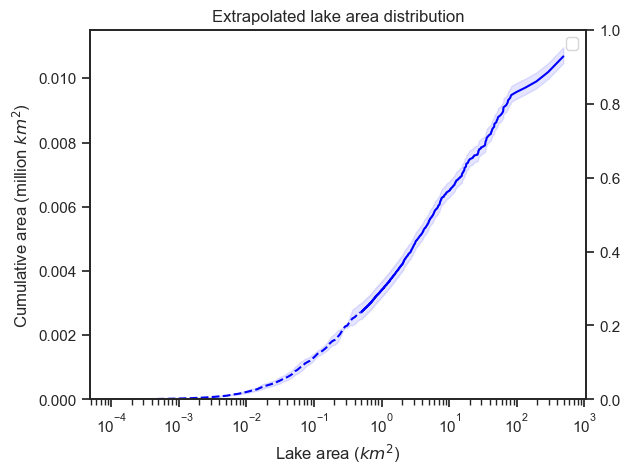

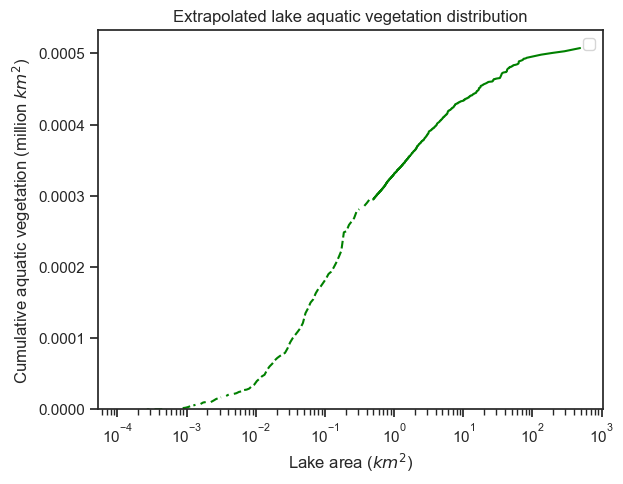

In [12]:
## Test plot extrap LAD, LEV
ax = lad_lr_trunc.plot_extrap_lad(normalized=False, error_bars=True, color='blue')
ax2=ax.twinx()
ymin, ymax = ax.get_ylim()
ax2.set_ylim([ymin/ymax, ymax/ymax])
ax.set_title('Extrapolated lake area distribution')
lad_lr_trunc.plot_extrap_lev(error_bars=False, color='green')
plt.tight_layout()
plt.title('Extrapolated lake aquatic vegetation distribution')


Example of loading a `LAD` object straight from a shapefile

In [16]:
lad_from_shp = LAD.from_shapefile(lad_hr_pth, area_var='Area', name='CIR', region_var='Region4')

## View its attributes using a custom function
lad_from_shp.get_public_attrs()

{'name': 'CIR',
 'orig_area_var': 'Area',
 'orig_region_var': 'Region4',
 'orig_idx_var': None,
 'name_var': None,
 'regions_': None,
 'isTruncated': False,
 'truncationLimits': None,
 'isBinned': False,
 'bins': None,
 'refBinnedLAD': None}